# Import

In [1]:
from ultralytics import YOLO
import cv2

# test

In [2]:
model = YOLO("yolov8s.pt")

C:\Users\user\AppData\Local\Temp\ipykernel_19352\3210802010.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'./data/train/{title}/0.pt')


bounding_boxes 내용:
 tensor([[104., 120., 147., 179.],
        [ 44., 140., 111., 243.],
        [148., 142., 213., 239.]]) 

classes 내용:
 tensor([1, 0, 0]) 

inputs 내용:
 tensor([[-0.1811, -0.1811, -0.1811,  ..., -0.1811, -0.1811, -0.1811],
        [-0.1811, -0.1811, -0.1811,  ..., -0.1158, -0.1158, -0.1158],
        [-0.1811, -0.1811, -0.1811,  ..., -0.0505, -0.0505, -0.0505],
        ...,
        [ 0.3159,  0.3159,  0.3159,  ...,  0.0674,  0.0674,  0.0674],
        [ 0.3159,  0.3159,  0.3159,  ...,  0.0674,  0.0674,  0.0674],
        [ 0.3159,  0.3159,  0.3159,  ...,  0.0674,  0.0674,  0.0674]]) 

instances 내용:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.,

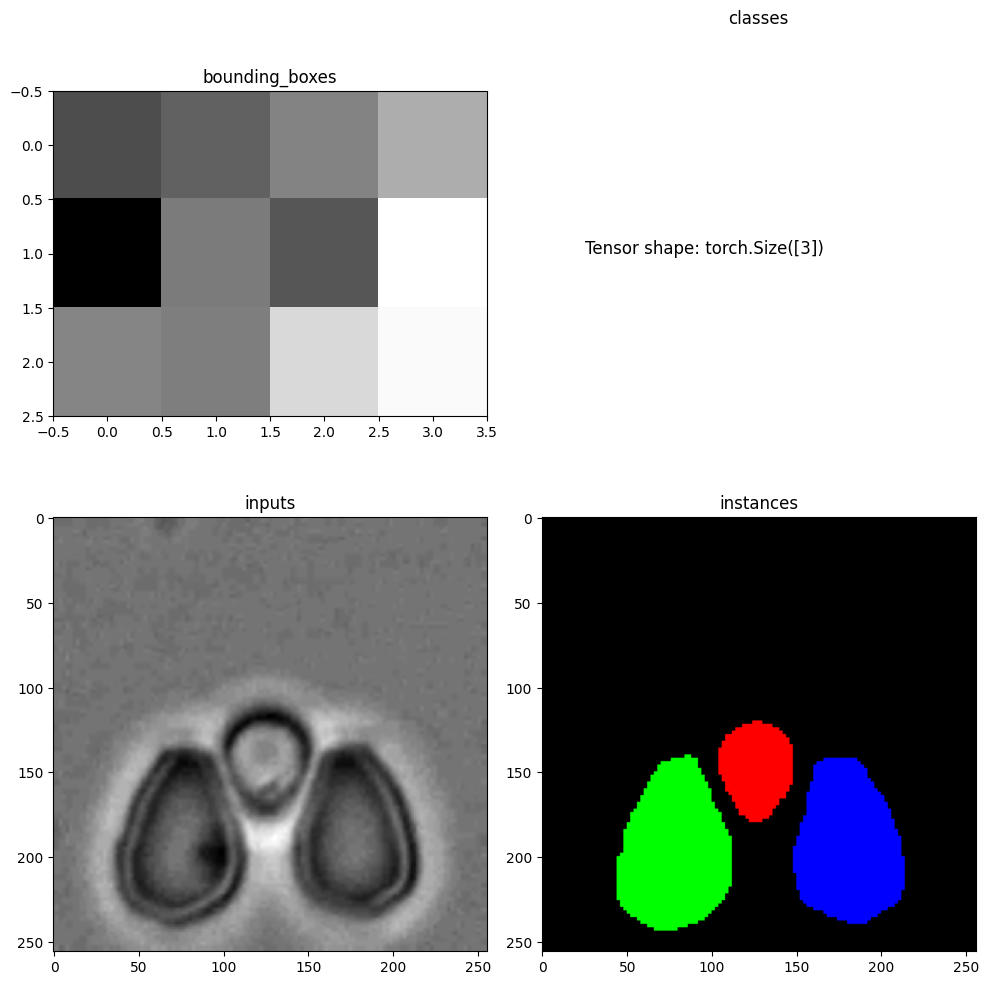

In [3]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))  # 더 큰 시각화를 위해

for index, title in enumerate(["bounding_boxes", "classes", "inputs", "instances"]):
    data = torch.load(f'./data/train/{title}/0.pt')

    plt.subplot(2, 2, index + 1)
    plt.title(title)

    # 시각화 가능한 텐서인지 확인
    if torch.is_tensor(data):
        if data.ndim == 3:  # 예: [C, H, W] → [H, W, C]로 전환 필요
            if data.shape[0] == 3:  # RGB 이미지
                img = data.permute(1, 2, 0).cpu().numpy()
                plt.imshow(img)
            else:
                plt.imshow(data[0].cpu(), cmap='gray')
        elif data.ndim == 2:
            plt.imshow(data.cpu(), cmap='gray')
        else:
            plt.text(0.1, 0.5, f"Tensor shape: {data.shape}", fontsize=12)
            plt.axis('off')
    else:
        # 텐서가 아니라면 문자열로 출력
        plt.text(0.1, 0.5, str(type(data)), fontsize=12)
        plt.axis('off')

    print(f"{title} 내용:\n", data, "\n")

plt.tight_layout()
plt.show()


In [4]:
import torch
import os
import numpy as np
from PIL import Image

def convert_to_yolo_format(box, img_width, img_height):
    x1, y1, x2, y2 = box
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return x_center, y_center, width, height

# 경로 설정
data_root = "./data/train"
output_image_dir = "./yolo_dataset/images/train"
output_label_dir = "./yolo_dataset/labels/train"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# 데이터 처리 루프
for i in range(1000):  # 예시로 0~99까지
    try:
        # 데이터 로딩
        image = torch.load(f"{data_root}/inputs/{i}.pt")
        boxes = torch.load(f"{data_root}/bounding_boxes/{i}.pt")
        classes = torch.load(f"{data_root}/classes/{i}.pt")

        # 이미지 차원 보정: [H,W] → [1,H,W], 또는 [C,H,W]
        if image.ndim == 2:
            image = image.unsqueeze(0)
        elif image.ndim == 3 and image.shape[0] not in [1, 3]:
            image = image.unsqueeze(0)  # 비표준 채널 처리

        # [C,H,W] → [H,W,C]
        image = image.permute(1, 2, 0).numpy()

        # 이미지 정규화 (0~255) 및 dtype 변환
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

        # 채널 차원 처리: (H, W, 1) → (H, W)
        if image.shape[-1] == 1:
            image = image.squeeze(-1)
            img_pil = Image.fromarray(image, mode='L')  # Grayscale
        else:
            img_pil = Image.fromarray(image)  # RGB

        h, w = image.shape[:2]

        # 이미지 저장
        img_pil.save(f"{output_image_dir}/{i:05}.jpg")

        # 라벨 YOLO 형식으로 저장
        with open(f"{output_label_dir}/{i:05}.txt", "w") as f:
            for box, cls in zip(boxes, classes):
                x, y, bw, bh = convert_to_yolo_format(box, w, h)
                f.write(f"{int(cls)} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

    except FileNotFoundError:
        print(f"File not found for index {i}, skipping.")
        continue
    except Exception as e:
        print(f"Error at index {i}: {e}")
        continue


C:\Users\user\AppData\Local\Temp\ipykernel_19352\3557974960.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(f"{data_root}/inputs/{i}.pt")
C:\Users\us

File not found for index 1, skipping.
File not found for index 2, skipping.
File not found for index 3, skipping.
File not found for index 6, skipping.
File not found for index 7, skipping.
File not found for index 9, skipping.
File not found for index 11, skipping.
File not found for index 12, skipping.
File not found for index 13, skipping.
File not found for index 15, skipping.
File not found for index 16, skipping.
File not found for index 20, skipping.
File not found for index 21, skipping.
File not found for index 22, skipping.
File not found for index 33, skipping.
File not found for index 34, skipping.
File not found for index 36, skipping.
File not found for index 41, skipping.
File not found for index 42, skipping.
File not found for index 44, skipping.
File not found for index 45, skipping.
File not found for index 46, skipping.
File not found for index 50, skipping.
File not found for index 53, skipping.
File not found for index 60, skipping.
File not found for index 65, sk

In [5]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')  # 혹은 yolov8s.yaml 등

model.train(
    data='data.yaml',
    epochs=20,
    imgsz=512,
    batch=16,
    name='yeast_detector'
)


Ultralytics 8.3.162  Python-3.12.10 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yeast_detector9, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

train: Scanning C:\Users\user\OneDrive\바탕 화면\코딩\3학년 프로젝트\yolo_dataset\labels\train... 296 images, 0 backgrounds, 237 corrupt: 100%|██████████| 296/296 [00:00<00:00, 1380.38it/s]

train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00000.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00004.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00008.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00010.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00018.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00019.jpg: ignoring corrupt image/label: Label c

train: New cache created: C:\Users\user\OneDrive\ \\3 \yolo_dataset\labels\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 25.914.4 MB/s, size: 7.7 KB)


val: Scanning C:\Users\user\OneDrive\바탕 화면\코딩\3학년 프로젝트\yolo_dataset\labels\train.cache... 296 images, 0 backgrounds, 237 corrupt: 100%|██████████| 296/296 [00:00<?, ?it/s]

train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00000.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00004.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00008.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00010.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00018.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: C:\Users\user\OneDrive\ \\3 \yolo_dataset\images\train\00019.jpg: ignoring corrupt image/label: Label c

Plotting labels to runs\detect\yeast_detector9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\yeast_detector9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.204      2.031      1.185         29        512: 100%|██████████| 4/4 [00:37<00:00,  9.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]

                   all         59        108      0.612      0.395      0.539      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G     0.8732      1.123       1.08         36        512: 100%|██████████| 4/4 [00:31<00:00,  7.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.62s/it]

                   all         59        108          1      0.981      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G     0.9418     0.8966      1.117         31        512: 100%|██████████| 4/4 [00:38<00:00,  9.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.43s/it]

                   all         59        108      0.996          1      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G     0.7872     0.7736      1.012         33        512: 100%|██████████| 4/4 [00:44<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.04s/it]

                   all         59        108      0.999          1      0.995      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G     0.7619     0.6273     0.9889         33        512: 100%|██████████| 4/4 [00:34<00:00,  8.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.15s/it]

                   all         59        108      0.999          1      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G     0.8554     0.6604      1.078         25        512: 100%|██████████| 4/4 [00:38<00:00,  9.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.78s/it]

                   all         59        108      0.999          1      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.7898     0.6807      1.017         25        512: 100%|██████████| 4/4 [00:36<00:00,  9.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.01s/it]

                   all         59        108      0.999          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.7802     0.7023     0.9801         34        512: 100%|██████████| 4/4 [00:34<00:00,  8.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.66s/it]

                   all         59        108      0.999          1      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.7911     0.6331      1.002         31        512: 100%|██████████| 4/4 [00:42<00:00, 10.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.11s/it]

                   all         59        108      0.999          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.7515     0.5859     0.9924         43        512: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.16s/it]

                   all         59        108      0.999          1      0.995      0.831


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.6279     0.5424     0.8919         21        512: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.70s/it]

                   all         59        108      0.998          1      0.995      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.6776     0.4717     0.9276         20        512: 100%|██████████| 4/4 [00:35<00:00,  8.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.23s/it]

                   all         59        108      0.999          1      0.995      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.6755     0.4677     0.9132         21        512: 100%|██████████| 4/4 [00:35<00:00,  8.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.73s/it]

                   all         59        108      0.999          1      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.6857     0.4961     0.9174         19        512: 100%|██████████| 4/4 [00:34<00:00,  8.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.32s/it]

                   all         59        108      0.999          1      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      0.616     0.4622      0.901         21        512: 100%|██████████| 4/4 [00:34<00:00,  8.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.59s/it]

                   all         59        108      0.999          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.5813     0.3877     0.8882         20        512: 100%|██████████| 4/4 [00:34<00:00,  8.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.44s/it]

                   all         59        108      0.999          1      0.995       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.5706     0.3905     0.8955         21        512: 100%|██████████| 4/4 [00:34<00:00,  8.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.31s/it]

                   all         59        108      0.999          1      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.5668      0.375     0.9285         21        512: 100%|██████████| 4/4 [00:34<00:00,  8.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.36s/it]

                   all         59        108      0.999          1      0.995      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.5794     0.3706      0.891         20        512: 100%|██████████| 4/4 [00:34<00:00,  8.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.47s/it]

                   all         59        108      0.999          1      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      0.556     0.3586     0.8904         20        512: 100%|██████████| 4/4 [00:37<00:00,  9.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.08s/it]

                   all         59        108      0.999          1      0.995       0.86



20 epochs completed in 0.284 hours.
Optimizer stripped from runs\detect\yeast_detector9\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\yeast_detector9\weights\best.pt, 22.5MB

Validating runs\detect\yeast_detector9\weights\best.pt...
Ultralytics 8.3.162  Python-3.12.10 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.48s/it]


                   all         59        108      0.999          1      0.995      0.864
Speed: 1.2ms preprocess, 210.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\yeast_detector9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000223710F88F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

파일 누락: Sample 0

image 1/1 c:\Users\user\OneDrive\ \\3 \temp_images\00001.jpg: 640x640 (no detections), 265.9ms
Speed: 3.7ms preprocess, 265.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


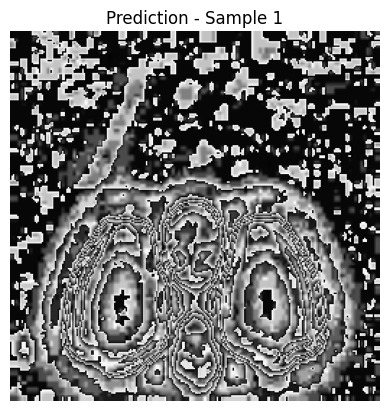


image 1/1 c:\Users\user\OneDrive\ \\3 \temp_images\00002.jpg: 640x640 1 traffic light, 292.6ms
Speed: 2.2ms preprocess, 292.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


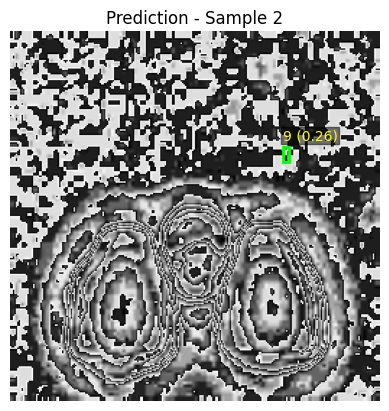


image 1/1 c:\Users\user\OneDrive\ \\3 \temp_images\00003.jpg: 640x640 (no detections), 180.4ms
Speed: 1.6ms preprocess, 180.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


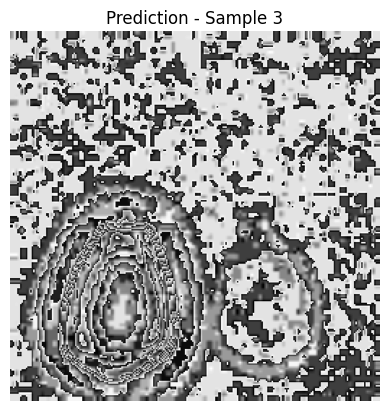

파일 누락: Sample 4
파일 누락: Sample 5

image 1/1 c:\Users\user\OneDrive\ \\3 \temp_images\00006.jpg: 640x640 (no detections), 229.0ms
Speed: 1.7ms preprocess, 229.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


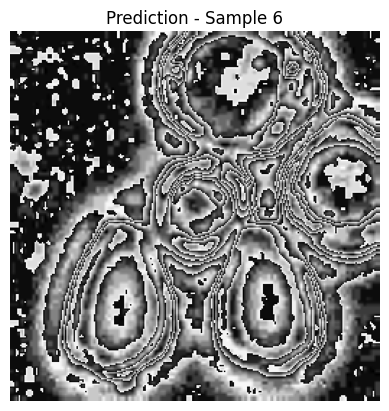

파일 누락: Sample 7
파일 누락: Sample 8

image 1/1 c:\Users\user\OneDrive\ \\3 \temp_images\00009.jpg: 640x640 1 clock, 294.9ms
Speed: 1.7ms preprocess, 294.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


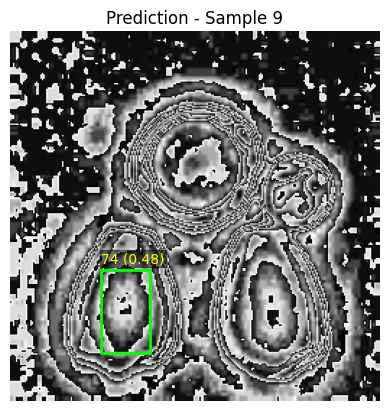

In [7]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# 경로 설정
data_root = "./data/test"
model_path = "./runs/detect/train/weights/best.pt"  # 학습된 모델
temp_img_dir = "./temp_images"
os.makedirs(temp_img_dir, exist_ok=True)

# 모델 로드
model = YOLO('yolov8s.pt')

# 시각화할 개수
num_samples = 10

for i in range(num_samples):
    try:
        image = torch.load(f"{data_root}/inputs/{i}.pt")

        # 채널 차원 정리
        if image.ndim == 2:
            image = image.unsqueeze(0)
        elif image.ndim == 3 and image.shape[0] not in [1, 3]:
            image = image.unsqueeze(0)

        image = image.permute(1, 2, 0).numpy()  # [C,H,W] → [H,W,C]
        image = (image * 255).astype("uint8")
        pil_img = Image.fromarray(image.squeeze() if image.shape[2] == 1 else image)
        temp_path = f"{temp_img_dir}/{i:05}.jpg"
        pil_img.save(temp_path)

        # 추론
        results = model(temp_path)[0]  # 첫 번째 결과만 사용

        # 시각화
        boxes = results.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
        cls = results.boxes.cls.cpu().numpy()     # class indices
        conf = results.boxes.conf.cpu().numpy()   # confidence scores

        # 시각화
        fig, ax = plt.subplots(1)
        ax.imshow(pil_img, cmap="gray" if image.shape[2] == 1 else None)

        for box, c, score in zip(boxes, cls, conf):
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       edgecolor='lime', linewidth=2, fill=False))
            ax.text(x1, y1 - 5, f"{int(c)} ({score:.2f})", color='yellow',
                    fontsize=10, bbox=dict(facecolor="black", alpha=0.5, pad=1))

        plt.title(f"Prediction - Sample {i}")
        plt.axis("off")
        plt.show()

    except FileNotFoundError:
        print(f"파일 누락: Sample {i}")
        continue
